In [1]:
import numpy as np
from matplotlib.pylab import *
from scipy.signal import stft as stft
from scipy.io.wavfile import read as wavread

import os
import random

FS = 8000
basedir = '/Users/jaewooklee/cs598ps-final/CS598Final/digit-data'

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
def read_all_file_from_dir(basedir):
    """
    Assumes all the WAV files start with a digit corresponding
    to the recording
    """
    all_digits = {i:[] for i in range(10)}
    for file in os.listdir(basedir):
        full_path = os.path.join(basedir, file)
        try:
            fs, x = wavread(full_path, FS)
            x = x.astype(float)
            assert fs == FS
            all_digits[int(file[0])].append(x)
        except Exception as e:
            print(e)
            pass
    
    return all_digits

def abs_stft(x):
    q, t, f = stft(x, nperseg=1024, noverlap=768)
    return (q, t, abs(f))

def fft_digits(digits):
    return {i: list(map(abs_stft, items)) for i, items in digits.items()}

def sample_digits(digits, num_sample=5):
    from random import sample
    
    samples = {i:random.sample(x, num_sample) for i, x in digits.items()}
    return fft_digits(samples)

def draw_specgram(samples, save_fig=None):
    def add_specgram(idx):
        q, t, f = sample
        subplot(5, 10, idx, title='Digit ' + str(digit)), pcolormesh(t, q, f**.3)
        
    rcParams['image.cmap'] = 'Greys'
    rcParams['figure.figsize'] = (14,10)

    suptitle('Time (sec) vs Frequency (Hz) Specgram')
    subplots_adjust(wspace=.5, hspace=.5)

    for digit in range(10):
        for i, sample in enumerate(samples[digit]):
            add_specgram(10 * i + digit + 1)
            
    if save_fig:
        savefig(save_fig)
    
def sample_reference_digits(fdigits):
    return {digit: [items[0]] for digit, items in fdigits.items()}

In [3]:
digits = read_all_file_from_dir(basedir)
fdigits = fft_digits(digits)
ref_digits = sample_reference_digits(fdigits)

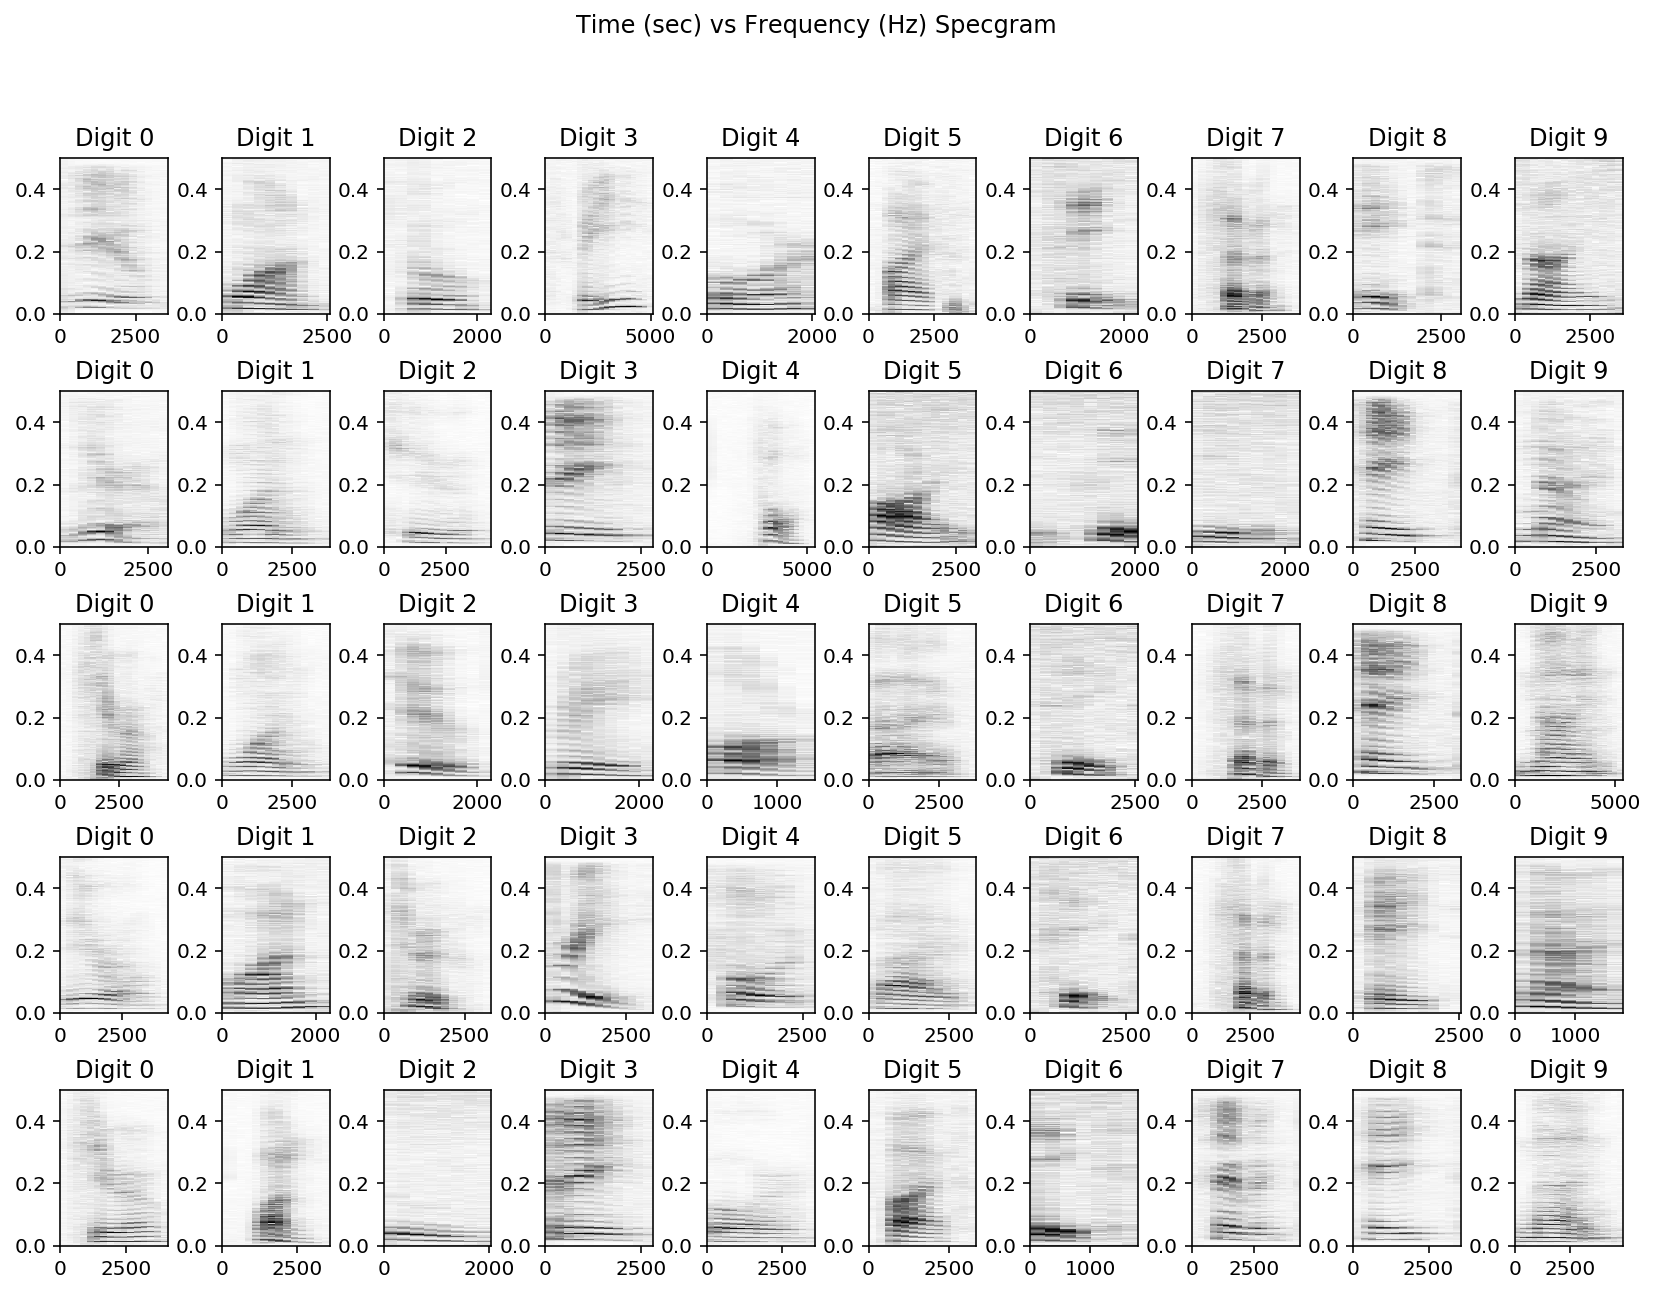

In [4]:
draw_specgram(sample_digits(digits), 'digits.png')

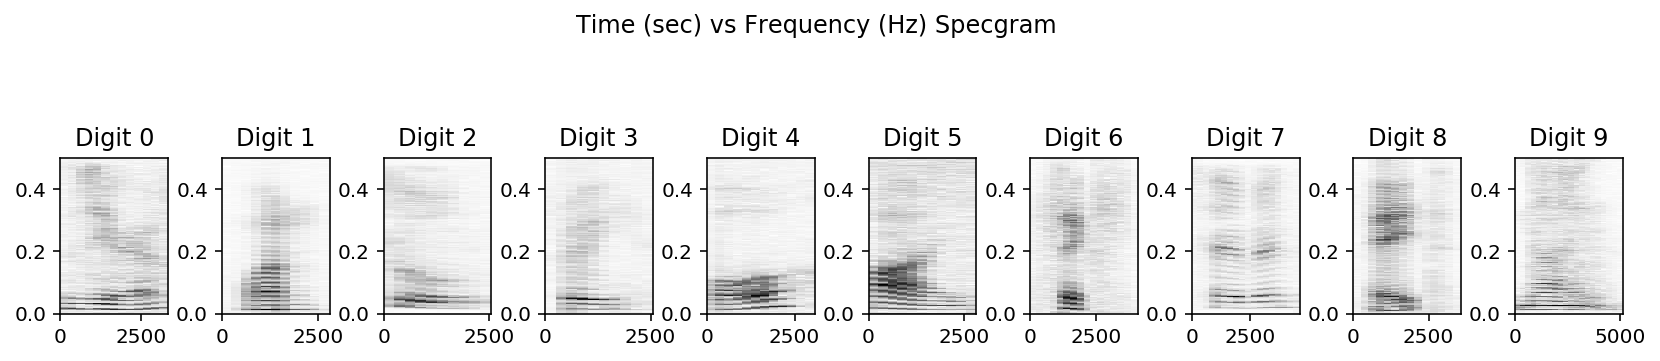

In [5]:
draw_specgram(ref_digits, 'reference_digits.png')

2.9223351398471893

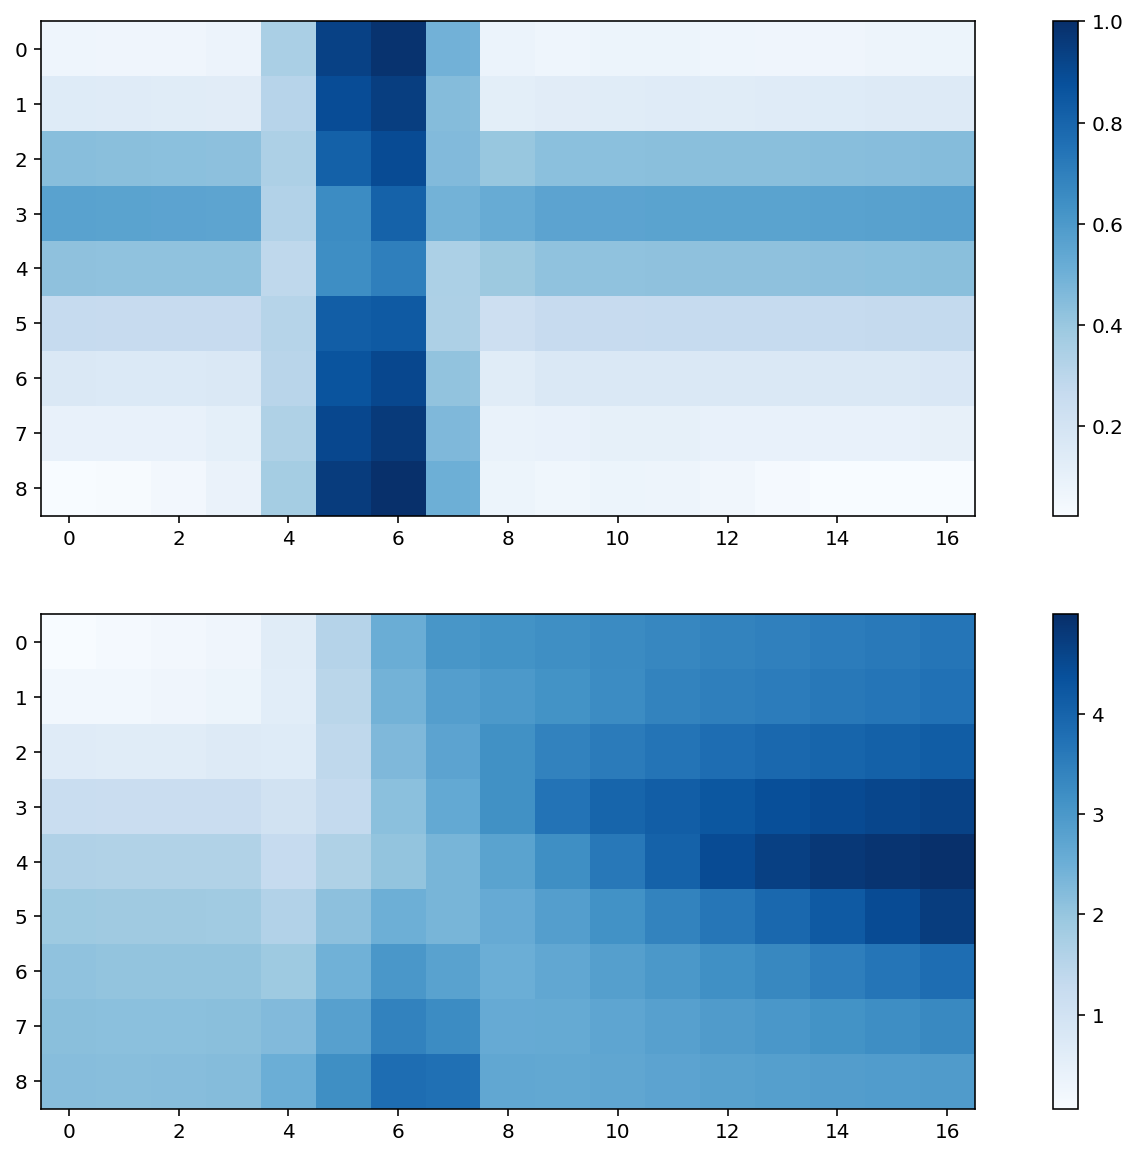

In [8]:
def eclid_dist(a, b):
    return np.linalg.norm(a - b)

def cos_sim(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def kl_div(a, b):
    a = a + 1e-5
    b = b + 1e-5
    return np.sum(a * np.log(a / b))

def js_div(a, b):
    m = 0.5 * (a + b)
    return 0.5 * kl_div(a, b) + 0.5 * kl_div(b, m)

def dtw(digit1, digit2, dist, draw=False):
    score = 0
    n, m = digit1.shape[1], digit2.shape[1]    
    D = [[None for _ in range(n)] for _ in range(m)]

    for x in range(0, n):
        for y in range(0, m):
            D[y][x] = dist(digit1[:, x], digit2[:, y])
    D  = np.array(D) / np.max(D)
    
    C = [[float('inf') for _ in range(n + 1)] for _ in range(m + 1)]
    C[0][0] = 0
    for x in range(1, n + 1):
        for y in range(1, m + 1):
            C[y][x] = min(C[y-1][x-1], C[y][x-1], C[y-1][x]) + D[y-1,x-1]
    C = np.array(C)
    
    if draw:
        subplot(2, 1, 1), imshow(D, cmap="Blues"), colorbar()
        subplot(2, 1, 2), imshow(C[1:, 1:], cmap="Blues"), colorbar()
    
    return C[-1][-1]
    
def dtw_predict(digit, ref_digit_freq, dist):
    scores = [dtw(digit, ref_digit, dist) for _, ref_digit in ref_digit_freq.items()]
    return np.argmin(scores)

def calc_acc(test_digit_freq, ref_digit_freq, dist_func):
    num_correct = 0
    total = 0

    digit_pred, digit_label = [], []
    conf_mat = []
    conf_mat_normalized = []
    
    for digit in range(10):
        row = np.array([0 for _ in range(10)])
        print(f'testing {digit}...')
        for test_digit in test_digit_freq[digit]:
            pred = dtw_predict(test_digit, ref_digit_freq, dist_func)
            if pred == digit:
                num_correct += 1
            row[pred] += 1
            total += 1

            digit_pred.append(pred)
            digit_label.append(digit)
        conf_mat.append(row)
        conf_mat_normalized.append(row / np.sum(row))
        
    acc = num_correct / total
    
    return acc, conf_mat, conf_mat_normalized

def draw_conf_matrix(conf_mat, conf_mat_normalized, dist_metric=''):
    subplot(2, 1, 1, title=f"Confusion Matrix for using {dist_metric}")
    imshow(conf_mat, aspect=1/2, cmap=matplotlib.colors.LinearSegmentedColormap.from_list('FooMap', [(1,1,1), (.1,.2,.4)]))
    xlabel("Predicted"), ylabel("Real")
    for i in range(len(conf_mat)):
        for j in range(len(conf_mat[0])):
            text(i, j, int(conf_mat[j][i]), color=[1,.5,.5], horizontalalignment='center', verticalalignment='center')

    subplot(2, 1, 2)
    imshow(conf_mat_normalized, aspect=1/2, cmap=matplotlib.colors.LinearSegmentedColormap.from_list('FooMap', [(1,1,1), (.1,.2,.4)]))
    xlabel("Predicted"), ylabel("Real")
    for i in range(len(conf_mat_normalized)):
        for j in range(len(conf_mat_normalized[0])):
            text(i, j, round(conf_mat_normalized[j][i], 3), color=[1,.5,.5], horizontalalignment='center', verticalalignment='center')

ref_digit_freq = {digit: ref_digits[digit][0][2] for digit in range(10)}
test_digit_freq = {digit: list(map(lambda x:x[2], items)) for digit, items in fdigits.items()}


dtw(test_digit_freq[6][0], test_digit_freq[6][2], eclid_dist, draw=True)

# Results for using Eclidian Distance

In [14]:
import time
start = time.time()
accuracy, conf_mat, conf_mat_normalized = calc_acc(test_digit_freq, ref_digit_freq, eclid_dist)
end = time.time()

testing 0...
testing 1...
testing 2...
testing 3...
testing 4...
testing 5...
testing 6...
testing 7...
testing 8...
testing 9...


Accuracy: 0.25066666666666665
It took 78.62259268760681 sec


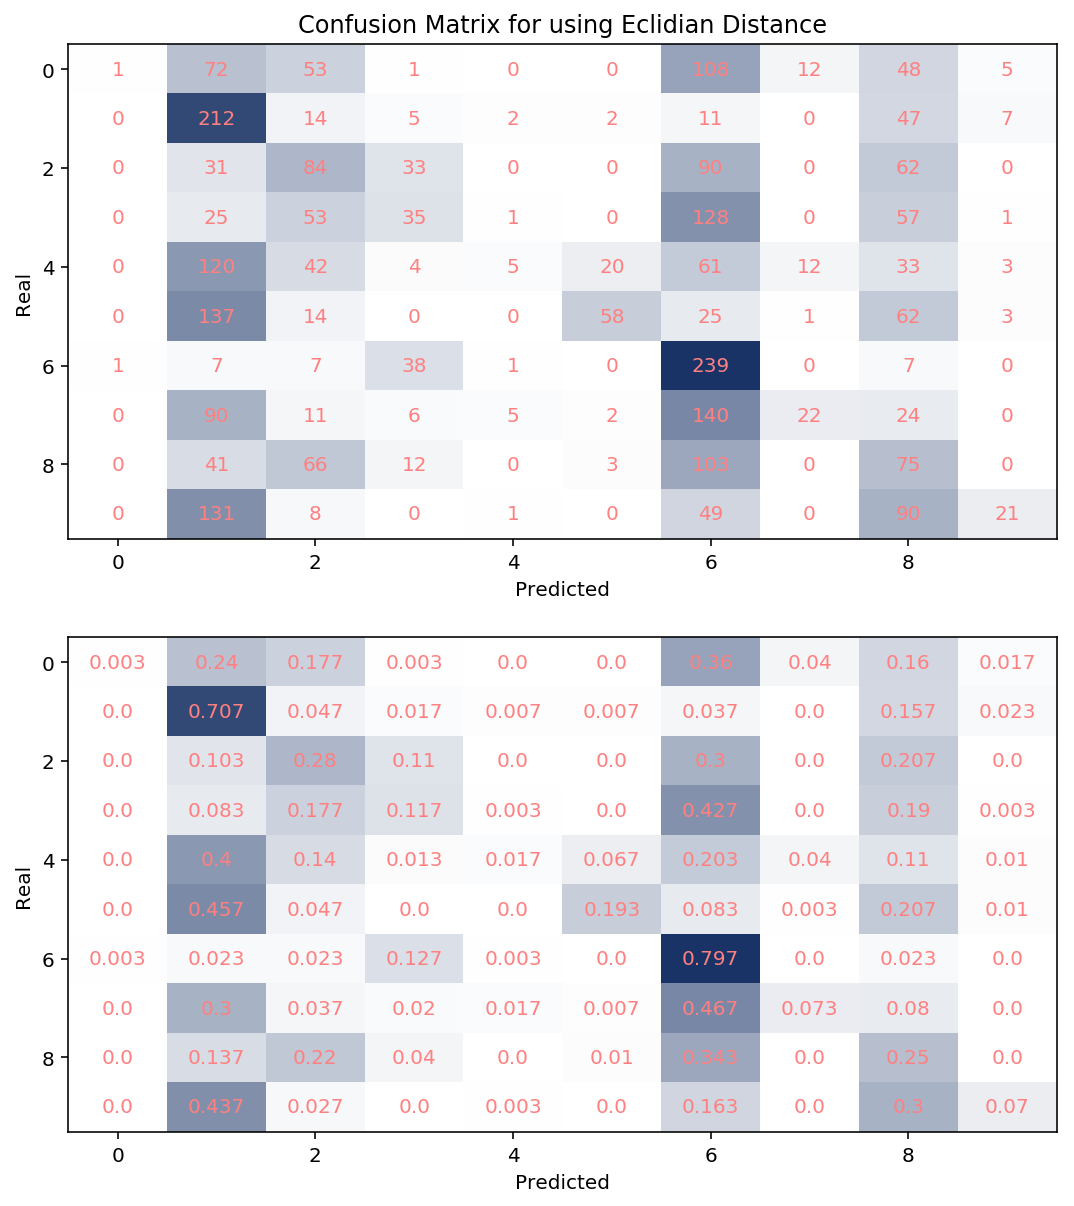

In [15]:
print(f"Accuracy: {accuracy}")
draw_conf_matrix(conf_mat, conf_mat_normalized, "Eclidian Distance")
print(f"It took {end - start} sec")

# Results for using Cosine Similarity

In [16]:
start = time.time()
accuracy, conf_mat, conf_mat_normalized = calc_acc(test_digit_freq, ref_digit_freq, cos_sim)
end = time.time()

testing 0...
testing 1...
testing 2...
testing 3...
testing 4...
testing 5...
testing 6...
testing 7...
testing 8...
testing 9...


Accuracy: 0.075
It took 115.39922308921814 sec


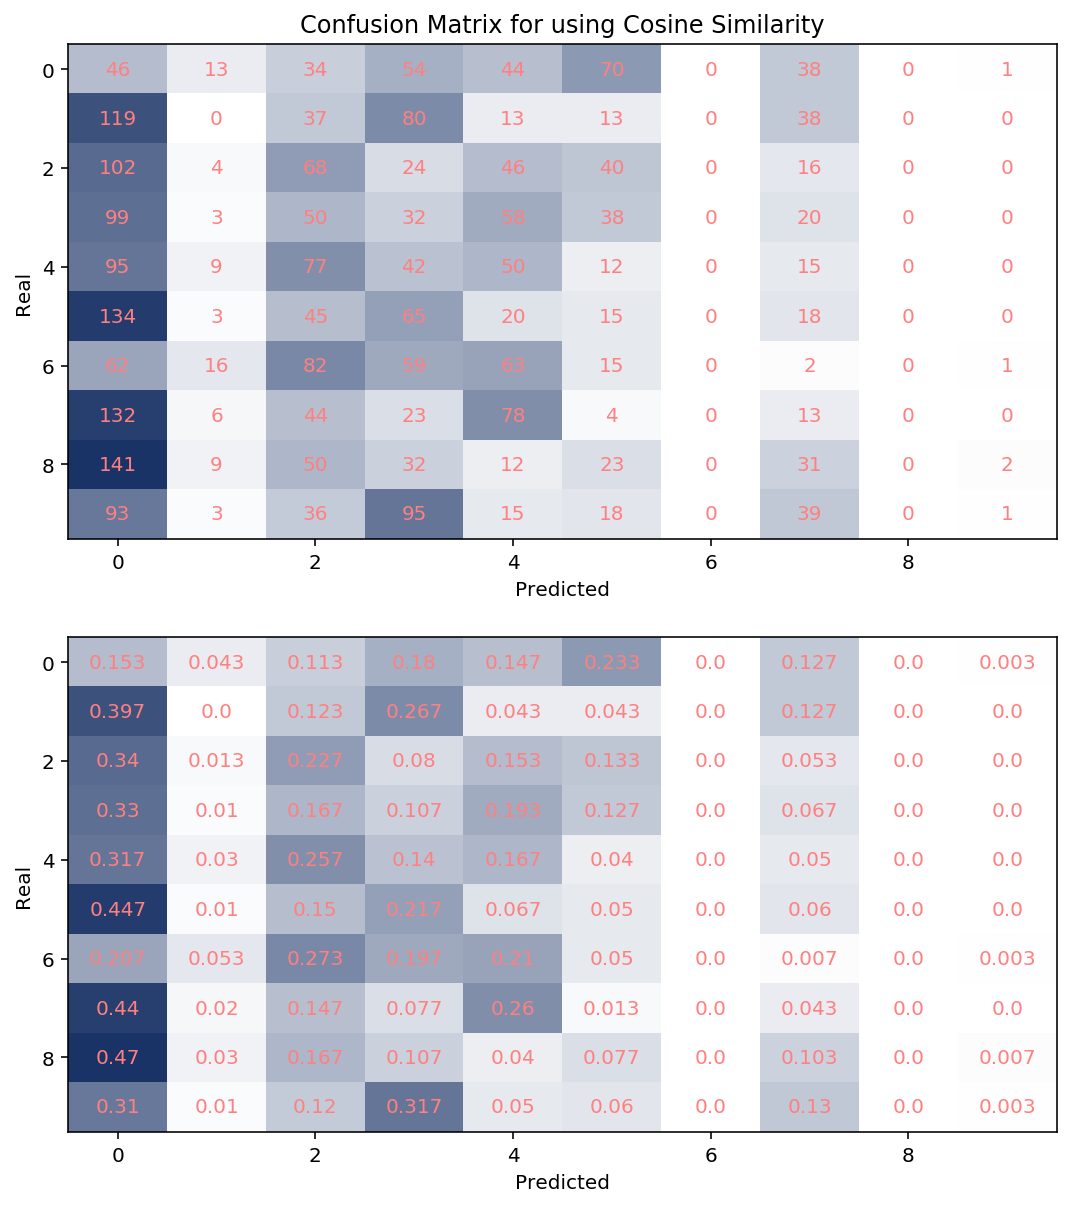

In [17]:
print(f"Accuracy: {accuracy}")
draw_conf_matrix(conf_mat, conf_mat_normalized, "Cosine Similarity")
print(f"It took {end - start} sec")

# Result for using KL-Divergence

In [18]:
start = time.time()
accuracy, conf_mat, conf_mat_normalized = calc_acc(test_digit_freq, ref_digit_freq, kl_div)
end = time.time()

testing 0...
testing 1...
testing 2...
testing 3...
testing 4...
testing 5...
testing 6...
testing 7...
testing 8...
testing 9...


Accuracy: 0.194
It took 153.47149205207825 sec


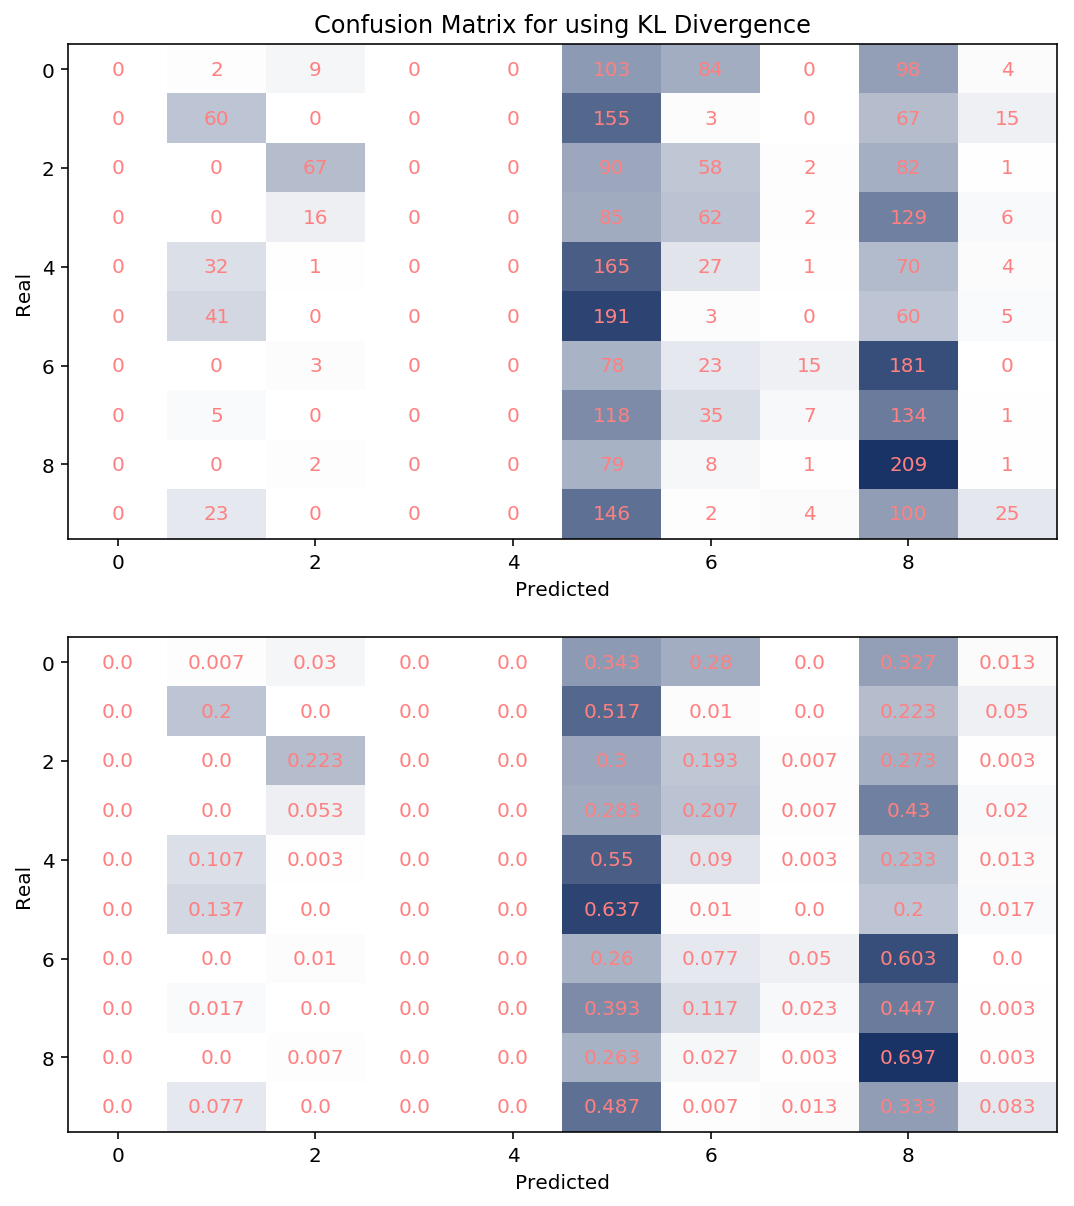

In [19]:
print(f"Accuracy: {accuracy}")
draw_conf_matrix(conf_mat, conf_mat_normalized, "KL Divergence")
print(f"It took {end - start} sec")

# Result for using Jensen Shannon Divergence

In [ ]:
start = time.time()
accuracy, conf_mat, conf_mat_normalized = calc_acc(test_digit_freq, ref_digit_freq, js_div)
end = time.time()

testing 0...
testing 1...
testing 2...
testing 3...
testing 4...
testing 5...
testing 6...
testing 7...
testing 8...
testing 9...


In [ ]:
print(f"Accuracy: {accuracy}")
draw_conf_matrix(conf_mat, conf_mat_normalized, "JS Divergence")
print(f"It took {end - start} sec")